# Implementation of face recognition using neural net 

In [3]:
%matplotlib inline

In [4]:
import cv2
import numpy as np
import os
from skimage import io
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


/Users/arjun/opencv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


#### Listing the path of all the images

In [6]:
DatasetPath = []
for i in os.listdir("yalefaces"):
    DatasetPath.append(os.path.join("yalefaces", i))

#### Reading each image and assigning respective labels

In [7]:
imageData = []
imageLabels = []

In [8]:
for i in DatasetPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

#### Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 * 150

In [9]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
imageDataFin = []
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 150, x: x + 150]
    imageDataFin.append(cropped)

In [10]:
c = np.array(imageDataFin)

In [11]:
c.shape

(165, 150, 150)

#### Splitting Dataset into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.7, random_state = 20)

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:
X_train.shape

(115, 150, 150)

In [15]:
X_test.shape

(50, 150, 150)

In [16]:
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [17]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#### Converting each 2d image into 1D vector

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

#### Preprocessing -PCA

Plot of amount of variance explained vs pcs


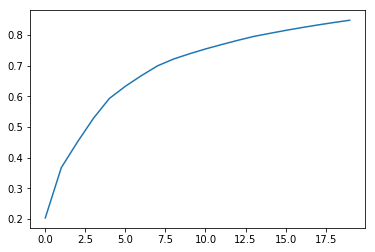

('Training PCA shape', (115, 20))
('Test PCA shape', (50, 20))
Eigen Faces


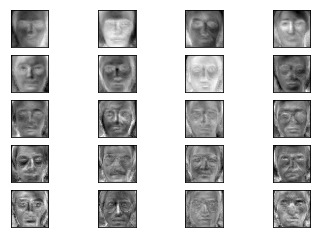

In [19]:
computed_pca = PCA(n_components = 20,whiten=True).fit(X_train)
XTr_pca = computed_pca.transform(X_train)

print("Plot of amount of variance explained vs pcs")
plt.plot(range(len(computed_pca.explained_variance_)),np.cumsum(computed_pca.explained_variance_ratio_))
plt.show()

XTs_pca = computed_pca.transform(X_test)
print("Training PCA shape",XTr_pca.shape)
print("Test PCA shape",XTs_pca.shape)


def plot_eigenfaces(images, h, w, rows=5, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_eigenfaces(computed_pca.components_,150,150)
print("Eigen Faces")

In [20]:
print("Original Training matrix shape", X_train.shape)
print("Original Testing matrix shape", X_test.shape)

('Original Training matrix shape', (115, 22500))
('Original Testing matrix shape', (50, 22500))


In [21]:
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(XTr_pca, y_train)

Fitting the classifier to the training set
Iteration 1, loss = 2.73465709
Validation score: 0.166667
Iteration 2, loss = 2.58757468
Validation score: 0.416667
Iteration 3, loss = 2.44355214
Validation score: 0.583333
Iteration 4, loss = 2.30278522
Validation score: 0.833333
Iteration 5, loss = 2.16533478
Validation score: 0.833333
Iteration 6, loss = 2.03151237
Validation score: 0.833333
Iteration 7, loss = 1.90139960
Validation score: 0.833333
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


/Users/arjun/opencv/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


In [22]:
y_pred = clf.predict(XTs_pca)
#print(y_pred,y_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.40      1.00      0.57         2
          1       0.60      0.60      0.60         5
          2       1.00      0.50      0.67         2
          3       0.60      1.00      0.75         3
          4       1.00      1.00      1.00         5
          5       1.00      0.80      0.89         5
          6       1.00      0.33      0.50         3
          7       0.75      1.00      0.86         3
          8       1.00      0.25      0.40         4
          9       1.00      1.00      1.00         3
         10       0.67      1.00      0.80         4
         11       1.00      0.67      0.80         3
         12       1.00      1.00      1.00         2
         13       0.75      0.75      0.75         4
         14       0.50      0.50      0.50         2

avg / total       0.83      0.76      0.75        50



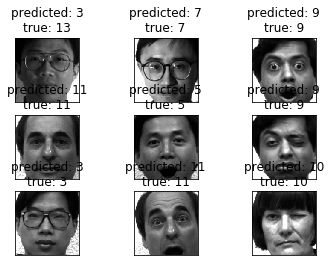

In [23]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=3):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        pred_name = y_pred[i]
        true_name = y_test[i]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(titles(y_pred, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)


#### Defining the model

In [24]:
model = Sequential()
model.add(Dense(512,input_shape=(XTr_pca.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                7695      
__________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#### Training

In [27]:
model.fit(XTr_pca, Y_train, batch_size=256, epochs=50, verbose=1, validation_data=(XTs_pca, Y_test))

Train on 115 samples, validate on 50 samples
Epoch 1/50
115/115 [==============================] - 0s 3ms/step - loss: 2.7296 - acc: 0.0783 - val_loss: 2.5648 - val_acc: 0.2800
Epoch 2/50
115/115 [==============================] - 0s 119us/step - loss: 2.4774 - acc: 0.3478 - val_loss: 2.4007 - val_acc: 0.6200
Epoch 3/50
115/115 [==============================] - 0s 129us/step - loss: 2.2988 - acc: 0.5565 - val_loss: 2.2415 - val_acc: 0.7800
Epoch 4/50
115/115 [==============================] - 0s 127us/step - loss: 2.0447 - acc: 0.8174 - val_loss: 2.0846 - val_acc: 0.8400
Epoch 5/50
115/115 [==============================] - 0s 131us/step - loss: 1.8332 - acc: 0.9130 - val_loss: 1.9333 - val_acc: 0.8600
Epoch 6/50
115/115 [==============================] - 0s 161us/step - loss: 1.6402 - acc: 0.9304 - val_loss: 1.7788 - val_acc: 0.8600
Epoch 7/50
115/115 [==============================] - 0s 174us/step - loss: 1.4324 - acc: 0.9565 - val_loss: 1.6204 - val_acc: 0.9000
Epoch 8/50
115/115 

#### Evaluating the performance

In [28]:
loss, accuracy = model.evaluate(XTs_pca,Y_test, verbose=0)

In [29]:
loss

0.43831513524055482

In [30]:
accuracy

0.88000000238418574

In [31]:
predicted_classes = model.predict_classes(XTs_pca)

In [32]:
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]

In [33]:
correct_classified_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38,
       39, 40, 42, 43, 44, 45, 46, 47, 48, 49])

In [34]:
incorrect_classified_indices

array([ 0, 20, 25, 28, 32, 41])

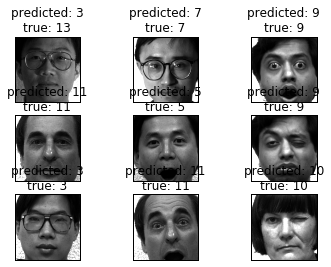

In [50]:
prediction_titles = list(titles(predicted_classes, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)

